In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from  datetime import datetime, timedelta
import gc
import numpy as np, pandas as pd
import lightgbm as lgb
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from scripts import m5_common
from tqdm.notebook import tqdm
from typing import Union
import random
from sklearn import datasets, linear_model

import mlflow
import mlflow.sklearn

pd.options.display.max_columns = 50

### Path

In [3]:
path = Path('/kaggle/m5_forecasting/')
assert(path.exists())

In [4]:
h = 28 
tr_last = 1913
fday = datetime(2016, 4, 25) 
fday

datetime.datetime(2016, 4, 25, 0, 0)

### Connect to MLflow server

In [5]:
# mlflow server --backend-store-uri mlruns/ --default-artifact-root mlruns/ --host 0.0.0.0 --port 5000
# server in /opt/mlflow_server/start.sh
remote_server_uri = "http://localhost:5000" # set to your server URI
mlflow.set_tracking_uri(remote_server_uri)  # or set the MLFLOW_TRACKING_URI in the env

In [6]:
mlflow.tracking.get_tracking_uri()

'http://localhost:5000'

In [7]:
mlflow.set_experiment('M5_Public')

### Ingest Data

In [8]:
%%time

prices, cal = m5_common.prepare_tables(path)

CPU times: user 1.4 s, sys: 184 ms, total: 1.58 s
Wall time: 1.58 s


In [9]:
weather_data_open_map = m5_common.prepare_open_map_weather(path/'weather_data_open_map.csv')

In [10]:
weather_data_open_map.head(30)

,year,month,mday,state_id,temp,feels_like,pressure,weather_id,rain_1h
0,2011,1,1,0,7.421875,3.279297,1024,800,0.000000
1,2011,1,1,1,14.281250,4.441406,1020,801,0.000000
2,2011,1,1,2,-7.878906,-20.406250,1010,804,0.000000
3,2011,1,2,0,9.109375,4.710938,1021,802,0.000000
4,2011,1,2,1,7.558594,2.169922,1030,801,0.000000
5,2011,1,2,2,-8.781250,-16.140625,1021,800,0.000000
6,2011,1,3,0,7.210938,4.371094,1017,701,0.700195
7,2011,1,3,1,10.531250,6.570312,1025,800,0.000000
8,2011,1,3,2,-3.210938,-8.351562,1018,803,0.000000
9,2011,1,4,0,8.078125,4.179688,1022,800,0.000000


In [11]:
weather_data_open_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6579 entries, 0 to 6578
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        6579 non-null   uint16 
 1   month       6579 non-null   uint8  
 2   mday        6579 non-null   uint8  
 3   state_id    6579 non-null   uint8  
 4   temp        6579 non-null   float16
 5   feels_like  6579 non-null   float16
 6   pressure    6579 non-null   uint16 
 7   weather_id  6579 non-null   uint16 
 8   rain_1h     6579 non-null   float16
dtypes: float16(3), uint16(3), uint8(3)
memory usage: 96.5 KB


In [12]:
event_name_1_map, event_type_1_map = m5_common.replace_cal_cols(cal)

In [13]:
cal[(cal.date > '2012-01-01') & (cal.date < '2012-01-05')]

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
338,2012-01-02,11149,1,3,1,2012,d_339,0,0,0,0,1.0,0.0,1.0
339,2012-01-03,11149,5,4,1,2012,d_340,0,0,0,0,1.0,1.0,1.0
340,2012-01-04,11149,6,5,1,2012,d_341,0,0,0,0,1.0,0.0,0.0


In [14]:
uint8_types= ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'month', 'wday', 'weekday', 
              'snap_CA', 'snap_TX', 'snap_WI']
m5_common.convert_uint8(cal, uint8_types)

In [15]:
def get_elapsed(dt, event_name='Christmas', col='event_name_1', event_map=event_name_1_map, before=False):
    dt.sort_values(['date'], ascending=[(not before)], inplace=True)
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    res = []
    event = event_map[event_name]
    for v,d in zip(dt[col].values, dt.date.values):
        if v == event:
            last_date = d
        elapsed = ((d-last_date).astype('timedelta64[D]') / day1)
        res.append(elapsed)
    field_name = f"{'before' if before else 'after'}_{event_name.lower().replace(' ', '_')}"
    dt[field_name] = res
    dt[field_name] = dt[field_name].fillna(0)
    dt[field_name] = dt[field_name].astype('int16')

In [16]:
# ellapsed_fields = ['Christmas', 'Easter', 'Ramadan starts']
# for f in ellapsed_fields:
#     get_elapsed(cal, f, 'event_name_1', event_name_1_map, False)

In [17]:
day_of_year = 'Dayofyear'

In [18]:
m5_common.add_days_before(cal)

In [19]:
easter_western = {2011: datetime(2011, 4, 24), 2012: datetime(2012, 4, 8), 2013: datetime(2013, 3, 31)
 , 2014: datetime(2014, 4, 20), 2015: datetime(2015, 4, 5), 2016: datetime(2016, 4, 27), 2017: datetime(2017, 4, 16)}

def add_days_before_special_date(dt, date_dict=easter_western, col_name='before_easter'):
    diff_list = []
    for d in cal['date']:
        year = d.year
        target = date_dict[year]
        diff = (target - d.to_pydatetime()).days
        if(diff < 0):
            target = date_dict[year + 1]
            diff = (target - d.to_pydatetime()).days
        diff_list.append(diff)
    dt[col_name] = diff_list
    dt[col_name] = dt[col_name].astype('uint16')

In [20]:
# add_days_before_special_date(cal)

In [21]:
cal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              1969 non-null   datetime64[ns]
 1   wm_yr_wk          1969 non-null   int16         
 2   weekday           1969 non-null   uint8         
 3   wday              1969 non-null   uint8         
 4   month             1969 non-null   uint8         
 5   year              1969 non-null   int16         
 6   d                 1969 non-null   object        
 7   event_name_1      1969 non-null   uint8         
 8   event_type_1      1969 non-null   uint8         
 9   event_name_2      1969 non-null   uint8         
 10  event_type_2      1969 non-null   uint8         
 11  snap_CA           1969 non-null   uint8         
 12  snap_TX           1969 non-null   uint8         
 13  snap_WI           1969 non-null   uint8         
 14  before_christmas  1969 n

In [22]:
cal

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,before_christmas
0,2011-01-29,11101,2,1,1,2011,d_1,0,0,0,0,0,0,0,330
1,2011-01-30,11101,3,2,1,2011,d_2,0,0,0,0,0,0,0,329
2,2011-01-31,11101,1,3,1,2011,d_3,0,0,0,0,0,0,0,328
3,2011-02-01,11101,5,4,2,2011,d_4,0,0,0,0,1,1,0,327
4,2011-02-02,11101,6,5,2,2011,d_5,0,0,0,0,1,0,1,326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,6,5,6,2016,d_1965,0,0,0,0,0,1,1,193
1965,2016-06-16,11620,4,6,6,2016,d_1966,0,0,0,0,0,0,0,192
1966,2016-06-17,11620,0,7,6,2016,d_1967,0,0,0,0,0,0,0,191
1967,2016-06-18,11621,2,1,6,2016,d_1968,0,0,0,0,0,0,0,190


In [23]:
FIRST_DAY = 1 # If you want to load all the data set it to '1' -->  Great  memory overflow  risk !

In [24]:
%%time

df = m5_common.create_dt(cal, prices, is_train=True, first_day= FIRST_DAY, tr_last=tr_last, path=path)

CPU times: user 41.8 s, sys: 5.77 s, total: 47.6 s
Wall time: 47.6 s


In [25]:
df.shape

(46027957, 27)

In [26]:
def merge_with_weather(dt):
    return dt.merge(weather_data_open_map, on=['year', 'month', 'mday', 'state_id'], how='left')

In [27]:
# df = merge_with_weather(df)

In [28]:
df.isnull().sum()

id                      0
item_id                 0
dept_id                 0
store_id                0
cat_id                  0
state_id                0
d                       0
sales                   0
date                    0
wm_yr_wk                0
weekday                 0
wday                    0
month                   0
year                    0
event_name_1            0
event_type_1            0
event_name_2            0
event_type_2            0
snap_CA                 0
snap_TX                 0
snap_WI                 0
before_christmas        0
sell_price              0
Dayofyear               0
week                    0
mday                    0
lag_price_1         30490
dtype: int64

In [29]:
df.shape

(46027957, 27)

In [30]:
def replace_cats(dt):
    m5_common.replace_cat(dt, 'wday')
    m5_common.replace_cat(dt, 'month')
    m5_common.replace_cat(dt, 'year')
    m5_common.replace_cat(dt, 'mday')

In [31]:
replace_cats(df)

{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6}
{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11}
{2011: 0, 2012: 1, 2013: 2, 2014: 3, 2015: 4, 2016: 5}
{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26, 28: 27, 29: 28, 30: 29, 31: 30}


In [32]:
%%time

ridge_regression = m5_common.RidgeRegressor()
ridge_regression.train(df)

CPU times: user 4.72 s, sys: 1.12 s, total: 5.83 s
Wall time: 4.41 s


In [33]:
%%time

def create_combined_cols(dt):
    m5_common.create_combined_col(dt, 'mday', 'weekday')
    m5_common.replace_cat(dt, 'mday_weekday')
    m5_common.create_combined_col(dt, 'event_name_1', 'event_name_2')
    m5_common.replace_cat(dt, 'event_name_1_event_name_2')

CPU times: user 21 µs, sys: 4 µs, total: 25 µs
Wall time: 4.05 µs


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46027957 entries, 4081 to 46025082
Data columns (total 27 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                object        
 1   item_id           int16         
 2   dept_id           int16         
 3   store_id          int16         
 4   cat_id            int16         
 5   state_id          int16         
 6   d                 object        
 7   sales             float16       
 8   date              datetime64[ns]
 9   wm_yr_wk          int16         
 10  weekday           uint8         
 11  wday              uint8         
 12  month             uint8         
 13  year              uint8         
 14  event_name_1      uint8         
 15  event_type_1      uint8         
 16  event_name_2      uint8         
 17  event_type_2      uint8         
 18  snap_CA           uint8         
 19  snap_TX           uint8         
 20  snap_WI           uint8         
 21  bef

In [35]:
# Fraction of zeros
df[df['sales'] == 0.].shape[0] / df.shape[0]

0.6115931671701179

In [36]:
df

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,before_christmas,sell_price,Dayofyear,week,mday,lag_price_1
4081,FOODS_1_001_CA_1_evaluation,1536,4,0,2,0,d_1,3.0,2011-01-29,11101,2,0,0,0,0,0,0,0,0,0,0,330,5.269531,29,4,28,NaN
4082,FOODS_1_001_CA_1_evaluation,1536,4,0,2,0,d_2,0.0,2011-01-30,11101,3,1,0,0,0,0,0,0,0,0,0,329,5.269531,30,4,29,5.269531
4083,FOODS_1_001_CA_1_evaluation,1536,4,0,2,0,d_3,0.0,2011-01-31,11101,1,2,0,0,0,0,0,0,0,0,0,328,5.269531,31,5,30,5.269531
4084,FOODS_1_001_CA_1_evaluation,1536,4,0,2,0,d_4,1.0,2011-02-01,11101,5,3,1,0,0,0,0,0,1,1,0,327,5.269531,32,5,0,5.269531
4085,FOODS_1_001_CA_1_evaluation,1536,4,0,2,0,d_5,4.0,2011-02-02,11101,6,4,1,0,0,0,0,0,1,0,1,326,5.269531,33,5,1,5.269531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45956915,HOUSEHOLD_2_516_WI_3_evaluation,2047,3,9,1,2,d_1909,0.0,2016-04-20,11612,6,4,3,5,0,0,0,0,0,0,0,249,1.000000,111,16,19,1.000000
45956916,HOUSEHOLD_2_516_WI_3_evaluation,2047,3,9,1,2,d_1910,0.0,2016-04-21,11612,4,5,3,5,0,0,0,0,0,0,0,248,1.000000,112,16,20,1.000000
45956917,HOUSEHOLD_2_516_WI_3_evaluation,2047,3,9,1,2,d_1911,0.0,2016-04-22,11612,0,6,3,5,0,0,0,0,0,0,0,247,1.000000,113,16,21,1.000000
46025081,HOUSEHOLD_2_516_WI_3_evaluation,2047,3,9,1,2,d_1912,0.0,2016-04-23,11613,2,0,3,5,0,0,0,0,0,0,0,246,1.000000,114,16,22,1.000000


### Feature Engineering

In [37]:
def mean_cols(dt, cols):
    dt[f"mean_{'_'.join(cols)}"] = dt[cols].mean(axis=1)

def create_fea(dt, dropna=True):
    
    wins = [7, 28]
    lags = [1, 7, 28]
    
    grouped_sales = dt[["id","sales"]].groupby("id")["sales"]
    
    for win in wins:
        mean_col = f'mean_{win}'
        emean_col = f'e{mean_col}' # exponential mean average
        esmean_col = f'es{mean_col}'
        dt[emean_col] = grouped_sales.transform(lambda x : x.ewm(span=win, adjust=False).mean())
        dt[esmean_col] = grouped_sales.transform(lambda x : x.ewm(alpha=1/win, adjust=False).mean())
        for lag in lags:
            dt[f'emean_{win}_{lag}'] = dt[["id", emean_col]].groupby("id").shift(lag)
            dt[f'esmean_{win}_{lag}'] = dt[["id", esmean_col]].groupby("id").shift(lag)
        del dt[emean_col]
        del dt[esmean_col]
            
    ra = [1, 2]
    for simple_lag in ra:
        dt[f'lag_{simple_lag}'] = dt[["id","sales"]].groupby("id")["sales"].shift(simple_lag)
        
    expanding_col = f'expanding_mean_2'
    dt[expanding_col] = grouped_sales.transform(lambda x : x.expanding(2).mean())
    dt[f'{expanding_col}_lag_1'] = dt[["id", expanding_col]].groupby("id").shift(1)
    del dt[expanding_col]
        
    if dropna == True:
        dt.dropna(inplace = True)
        
    dt['ridge_predict'] = ridge_regression.predict(dt)
    dt['ridge_predict'] = dt['ridge_predict'].astype('float16')

In [38]:
%%time

create_fea(df)

CPU times: user 2min 9s, sys: 12.1 s, total: 2min 21s
Wall time: 2min 19s


In [39]:
df.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,before_christmas,sell_price,Dayofyear,week,mday,lag_price_1,emean_7_1,esmean_7_1,emean_7_7,esmean_7_7,emean_7_28,esmean_7_28,emean_28_1,esmean_28_1,emean_28_7,esmean_28_7,emean_28_28,esmean_28_28,lag_1,lag_2,expanding_mean_2_lag_1,ridge_predict
342559,FOODS_1_001_CA_1_evaluation,1536,4,0,2,0,d_29,2.0,2011-02-26,11105,2,0,1,0,0,0,0,0,0,0,0,302,5.269531,57,8,25,5.269531,2.207031,1.852539,1.245117,1.296875,3.000000,3.000000,1.770508,2.027344,1.594727,2.021484,3.000000,3.000000,4.0,2.0,1.392578,1.710938
342560,FOODS_1_001_CA_1_evaluation,1536,4,0,2,0,d_30,2.0,2011-02-27,11105,3,1,1,0,0,0,0,0,0,0,0,301,5.269531,58,8,26,5.269531,2.156250,1.874023,1.433594,1.397461,2.250000,2.572266,1.786133,2.027344,1.623047,2.021484,2.792969,2.892578,2.0,4.0,1.414062,1.642578
342561,FOODS_1_001_CA_1_evaluation,1536,4,0,2,0,d_31,0.0,2011-02-28,11105,1,2,1,0,0,0,0,0,0,0,0,300,5.269531,59,9,27,5.269531,2.117188,1.891602,1.075195,1.197266,1.687500,2.203125,1.800781,2.025391,1.510742,1.949219,2.599609,2.789062,2.0,2.0,1.433594,1.572266
342562,FOODS_1_001_CA_1_evaluation,1536,4,0,2,0,d_32,2.0,2011-03-01,11105,5,3,2,0,0,0,0,0,1,1,0,299,5.269531,60,9,0,5.269531,1.587891,1.621094,1.306641,1.312500,1.515625,2.031250,1.676758,1.953125,1.544922,1.951172,2.490234,2.726562,0.0,2.0,1.386719,1.687500
342563,FOODS_1_001_CA_1_evaluation,1536,4,0,2,0,d_33,1.0,2011-03-02,11105,6,4,2,0,0,0,0,0,1,0,1,298,5.269531,61,9,1,5.269531,1.690430,1.675781,1.479492,1.410156,2.136719,2.312500,1.699219,1.955078,1.576172,1.953125,2.593750,2.771484,2.0,0.0,1.406250,1.613281


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45174237 entries, 342559 to 46025082
Data columns (total 43 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   id                      object        
 1   item_id                 int16         
 2   dept_id                 int16         
 3   store_id                int16         
 4   cat_id                  int16         
 5   state_id                int16         
 6   d                       object        
 7   sales                   float16       
 8   date                    datetime64[ns]
 9   wm_yr_wk                int16         
 10  weekday                 uint8         
 11  wday                    uint8         
 12  month                   uint8         
 13  year                    uint8         
 14  event_name_1            uint8         
 15  event_type_1            uint8         
 16  event_name_2            uint8         
 17  event_type_2            uint8         


In [41]:
feature_lags = [f'lag_{i}' for i in range(1, 8)]
feature_pool = ['before_christmas', 'sell_price', 'Dayofyear', 'week', 'lag_price_1', 'emean_7_7', 'esmean_7_7', 'emean_7_28',            
                'esmean_7_28', 'emean_28_7', 'esmean_28_7', 'emean_28_28', 'esmean_28_28'] + feature_lags

if not 'cat_feats' in locals():
    cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id', 
             "event_name_1", "event_name_2", "event_type_1", "event_type_2", 'snap_CA', 'snap_TX', 'snap_WI']

#### Random feature selection

In [42]:
# import random

# def reduce_features(feature_pool, size):    
#     random.shuffle(feature_pool)
#     return feature_pool[:size]

# selected_features = reduce_features(feature_pool, 15)

# selected_features = selected_features + cat_feats + ['id', 'date', 'sales', 'wday', 'month', 'year', 'mday']
# selected_features.sort()

# print('selected_features', selected_features)

In [43]:
def remove_features(dt, selected_features):
    for col in dt.columns:
        if col not in selected_features:
            del dt[col]

In [44]:
if not 'selected_features' in locals():
    selected_features = list(df.columns)

remove_features(df, selected_features)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45174237 entries, 342559 to 46025082
Data columns (total 43 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   id                      object        
 1   item_id                 int16         
 2   dept_id                 int16         
 3   store_id                int16         
 4   cat_id                  int16         
 5   state_id                int16         
 6   d                       object        
 7   sales                   float16       
 8   date                    datetime64[ns]
 9   wm_yr_wk                int16         
 10  weekday                 uint8         
 11  wday                    uint8         
 12  month                   uint8         
 13  year                    uint8         
 14  event_name_1            uint8         
 15  event_type_1            uint8         
 16  event_name_2            uint8         
 17  event_type_2            uint8         


In [46]:
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)

In [47]:
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday"]
train_cols = df.columns[~df.columns.isin(useless_cols)]
X_train = df[train_cols]
y_train = df["sales"]

seed_everything(777)

size_valid_set = 2_000_000
fake_valid_inds = np.random.choice(X_train.index.values, size_valid_set, replace = False)
train_inds = np.setdiff1d(X_train.index.values, fake_valid_inds)

In [48]:
X = X_train.loc[train_inds]
y = y_train.loc[train_inds]

X_valid = X_train.loc[fake_valid_inds]
y_valid = y_train.loc[fake_valid_inds]

In [49]:
del df
gc.collect()

176

In [50]:
if not 'n_estimators' in locals():
    n_estimators = 300
    
if not 'tweedie_variance_power' in locals():
    tweedie_variance_power = 1.28
    
if not 'sub_row' in locals():
    sub_row = 0.75
    
if not 'bagging_freq' in locals():
    bagging_freq = 1
    
if not 'learning_rate' in locals():
    learning_rate = 0.075

leave_size = 10
params = {
        'boosting_type': 'gbdt',
        "objective" : "tweedie",
        'tweedie_variance_power': tweedie_variance_power,
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : learning_rate,
#         "sub_feature" : 0.8,
        "sub_row" : sub_row,
        "bagging_freq" : bagging_freq,
#         "lambda_l1" : 0.2,
        "lambda_l2" : 0.1,
        "nthread" : 10,
        "metric": ["rmse"],
        'verbosity': 20,
        'num_leaves': 2**leave_size-1,
        "min_data_in_leaf": 2**(leave_size + 1)-1,
        "n_estimators": n_estimators
}

In [51]:
class Importance():
    
    def __init__(self, model, eval_metric):
        self.model, self.eval_metric = model, eval_metric
        self.feature_importances = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)),
                                           columns=['feature', 'importance'])

    def plot_feature_importance(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Plot default feature importance.

        :param drop_null_importance: drop columns with null feature importance
        :param top_n: show top n columns
        :return:
        """

        top_feats = self.get_top_features(drop_null_importance, top_n)
        feature_importances = self.feature_importances.loc[self.feature_importances['feature'].isin(top_feats)]
        feature_importances['feature'] = feature_importances['feature'].astype(str)
        top_feats = [str(i) for i in top_feats]
        a4_dims = (11.7, 8.27)
        fig, ax = plt.subplots(figsize=a4_dims)
        sns.barplot(data=feature_importances, x='importance', y='feature', orient='h', order=top_feats, ax=ax)
        plt.title('Feature importances')

    def get_top_features(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Get top features by importance.

        :param drop_null_importance:
        :param top_n:
        :return:
        """
        grouped_feats = self.feature_importances.groupby(['feature'])['importance'].mean()
        if drop_null_importance:
            grouped_feats = grouped_feats[grouped_feats != 0]
        return list(grouped_feats.sort_values(ascending=False).index)[:top_n]
    
    def plot_metric(self):
        """
        Plot training progress.
        Inspired by `plot_metric` from https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/plotting.html

        :return:
        """
        full_evals_results = pd.DataFrame()
        for model in [self.model]:
            evals_result = pd.DataFrame()
            for k in model.evals_result_.keys():
                evals_result[k] = model.evals_result_[k][self.eval_metric]
            evals_result = evals_result.reset_index().rename(columns={'index': 'iteration'})
            full_evals_results = full_evals_results.append(evals_result)

        full_evals_results = full_evals_results.melt(id_vars=['iteration']).rename(columns={'value': self.eval_metric,
                                                                                            'variable': 'dataset'})
        sns.lineplot(data=full_evals_results, x='iteration', y=self.eval_metric, hue='dataset')
#         categorical_feature  plt.title('Training progress')

In [52]:
def run_pred(m_lgb):
    max_lags = h * 2 + 1
    sub = 0.
    cols = [f"F{i}" for i in range(1,29)]
    te = m5_common.create_dt(cal, prices, False, first_day=FIRST_DAY, path=path)
    replace_cats(te)

    for tdelta in tqdm(range(0, h), total=h):
        day = fday + timedelta(days=tdelta)
        print(tdelta, day)
        tst = te[(te.date >= day - timedelta(days=max_lags)) & (te.date <= day)].copy()
        create_fea(tst, False)
        remove_features(tst, selected_features)
        tst = tst.loc[tst.date == day, train_cols]
        te.loc[te.date == day, "sales"] = m_lgb.predict(tst)

    te_sub = te.loc[te.date >= fday, ["id", "sales"]].copy()
    te_sub["id"] = te_sub["id"].str.replace("evaluation$", "validation")
    te_sub["F"] = [f"F{rank}" for rank in te_sub.groupby("id")["id"].cumcount()+1]
    te_sub = te_sub.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
    te_sub.fillna(0., inplace = True)
    te_sub.sort_values("id", inplace = True)
    te_sub.reset_index(drop=True, inplace = True)
    sub = te_sub

    sub2 = sub.copy()
    sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
    sub = pd.concat([sub, sub2], axis=0, sort=False)
    sub.to_csv("submission.csv",index=False)

In [53]:
## evaluation metric
## from https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/133834 and edited to get scores at all levels
class WRMSSEEvaluator(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()

        train_df['all_id'] = 0  # for lv1 aggregation

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')].columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')].columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()

        self.group_ids = (
            'all_id',
            'cat_id',
            'state_id',
            'dept_id',
            'store_id',
            'item_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )

        for i, group_id in enumerate(tqdm(self.group_ids)):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)[valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns].set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index().rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left', on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd']).unstack(level=2)['value']
        weight_df = weight_df.loc[zip(self.train_df.item_id, self.train_df.store_id), :].reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns], weight_df], axis=1, sort=False)
        return weight_df

    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')
        return (score / scale).map(np.sqrt)

    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds], axis=1, sort=False)

        group_ids = []
        all_scores = []
        for i, group_id in enumerate(self.group_ids):
            lv_scores = self.rmsse(valid_preds.groupby(group_id)[self.valid_target_columns].sum(), i + 1)
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, sort=False).prod(axis=1)
            group_ids.append(group_id)
            all_scores.append(lv_scores.sum())

        return group_ids, all_scores

## public LB rank
def get_lb_rank(df_lb, score):
    """
    Get rank on public LB as of 2020-05-31 23:59:59
    """
    return (df_lb.Score <= score).sum() + 1

def validation_ranking(mlflow):
    ## new train data
    df_train_full = pd.read_csv(path/"sales_train_evaluation.csv")
    df_train_full.iloc[:, -31:].head()
    
    df_lb = pd.read_csv(path/"m5-forecasting-accuracy-publicleaderboard-rank.csv")
    
    ## reading data
    df_calendar = pd.read_csv(path/"calendar.csv")
    df_prices = pd.read_csv(path/"sell_prices.csv")
    df_sample_submission = pd.read_csv(path/"sample_submission.csv")
    df_sample_submission["order"] = range(df_sample_submission.shape[0])

    df_train = df_train_full.iloc[:, :-28]
    df_valid = df_train_full.iloc[:, -28:]

    evaluator = WRMSSEEvaluator(df_train, df_valid, df_calendar, df_prices)
    
    ## structure of validation data
    preds_valid = df_valid.copy() + np.random.randint(100, size = df_valid.shape)

    ## evaluating submission from public kernel M5 - Three shades of Dark: Darker magic
    preds_valid = pd.read_csv("submission.csv")
    preds_valid = preds_valid[preds_valid.id.str.contains("validation")]
    preds_valid = preds_valid.merge(df_sample_submission[["id", "order"]], on = "id").sort_values("order").drop(["id", "order"], axis = 1).reset_index(drop = True)
    preds_valid.rename(columns = {
        "F1": "d_1914", "F2": "d_1915", "F3": "d_1916", "F4": "d_1917", "F5": "d_1918", "F6": "d_1919", "F7": "d_1920",
        "F8": "d_1921", "F9": "d_1922", "F10": "d_1923", "F11": "d_1924", "F12": "d_1925", "F13": "d_1926", "F14": "d_1927",
        "F15": "d_1928", "F16": "d_1929", "F17": "d_1930", "F18": "d_1931", "F19": "d_1932", "F20": "d_1933", "F21": "d_1934",
        "F22": "d_1935", "F23": "d_1936", "F24": "d_1937", "F25": "d_1938", "F26": "d_1939", "F27": "d_1940", "F28": "d_1941"
    }, inplace = True)

    groups, scores = evaluator.score(preds_valid)

    score_public_lb = np.mean(scores)
    score_public_rank = get_lb_rank(df_lb, score_public_lb)

    for i in range(len(groups)):
        print(f"Score for group {groups[i]}: {round(scores[i], 5)}")

    print(f"\nPublic LB Score: {round(score_public_lb, 5)}")
    mlflow.log_metric(key="Public LB Score", value=round(score_public_lb, 5))
    mlflow.set_tag(key="Public LB Rank", value=str(score_public_rank))

In [54]:
def importance_to_string(X_train, m_lgb_regressor):
    importances = [f'{f} : {c}' for (c, f) in zip(X_train.columns, m_lgb_regressor.feature_importances_)]
    importances.sort()
    return ','.join(importances)

In [55]:
%%time

with mlflow.start_run():
    mlflow.log_params(params)
    mlflow.log_param(key="features", value=str(selected_features))
    m_lgb_regressor = lgb.LGBMRegressor(**params)
    m_lgb_regressor.fit(X=X, y=y, 
              eval_set=[(X, y), (X_valid, y_valid)],
              eval_names=['train sales', 'valid sales'], 
              eval_metric=params['metric'],
              verbose=params['verbosity'],
              early_stopping_rounds=100,
              categorical_feature=cat_feats)
    mlflow.log_metric(key="train_rmse_best", value=m_lgb_regressor.best_score_['train sales']['rmse'])
    mlflow.log_metric(key="valid_rmse_best", value=m_lgb_regressor.best_score_['valid sales']['rmse'])
    mlflow.set_tag(key="importance", value=importance_to_string(X_train, m_lgb_regressor))
    run_pred(m_lgb_regressor)
    validation_ranking(mlflow)

/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['cat_id', 'dept_id', 'event_name_1', 'event_name_2', 'event_type_1', 'event_type_2', 'item_id', 'snap_CA', 'snap_TX', 'snap_WI', 'state_id', 'store_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds
[20]	train sales's rmse: 2.83278	valid sales's rmse: 2.75912
[40]	train sales's rmse: 2.30257	valid sales's rmse: 2.24037
[60]	train sales's rmse: 2.22791	valid sales's rmse: 2.17637
[80]	train sales's rmse: 2.20058	valid sales's rmse: 2.15935
[100]	train sales's rmse: 2.18522	valid sales's rmse: 2.14922
[120]	train sales's rmse: 2.17465	valid sales's rmse: 2.14396
[140]	train sales's rmse: 2.16408	valid sales's rmse: 2.13807
[160]	train sales's rmse: 2.15642	valid sales's rmse: 2.13376
[180]	train sales's rmse: 2.14869	valid sales's rmse: 2.12891
[200]	train sales's rmse: 2.14277	valid sales's rmse: 2.12646
[220]	train sales's rmse: 2.13666	valid sales's rmse: 2.12363
[240]	train sales's rmse: 2.13087	valid sales's rmse: 2.1211
[260]	train sales's rmse: 2.12562	valid sales's rmse: 2.11837
[280]	train sales's rmse: 2.12152	valid sales's rmse: 2.11698
[300]	train sales's rmse: 2.1176	valid sales's rmse: 2.11575
Did not meet e

0 2016-04-25 00:00:00
1 2016-04-26 00:00:00
2 2016-04-27 00:00:00
3 2016-04-28 00:00:00
4 2016-04-29 00:00:00
5 2016-04-30 00:00:00
6 2016-05-01 00:00:00
7 2016-05-02 00:00:00
8 2016-05-03 00:00:00
9 2016-05-04 00:00:00
10 2016-05-05 00:00:00
11 2016-05-06 00:00:00
12 2016-05-07 00:00:00
13 2016-05-08 00:00:00
14 2016-05-09 00:00:00
15 2016-05-10 00:00:00
16 2016-05-11 00:00:00
17 2016-05-12 00:00:00
18 2016-05-13 00:00:00
19 2016-05-14 00:00:00
20 2016-05-15 00:00:00
21 2016-05-16 00:00:00
22 2016-05-17 00:00:00
23 2016-05-18 00:00:00
24 2016-05-19 00:00:00
25 2016-05-20 00:00:00
26 2016-05-21 00:00:00
27 2016-05-22 00:00:00




Score for group all_id: 0.19427
Score for group cat_id: 0.2552
Score for group state_id: 0.29766
Score for group dept_id: 0.35297
Score for group store_id: 0.39132
Score for group item_id: 0.79809
Score for group ['state_id', 'cat_id']: 0.3633
Score for group ['state_id', 'dept_id']: 0.45096
Score for group ['store_id', 'cat_id']: 0.46312
Score for group ['store_id', 'dept_id']: 0.55748
Score for group ['item_id', 'state_id']: 0.81631
Score for group ['item_id', 'store_id']: 0.82574

Public LB Score: 0.48053
CPU times: user 7h 36min 3s, sys: 1min 59s, total: 7h 38min 3s
Wall time: 1h 4min 1s


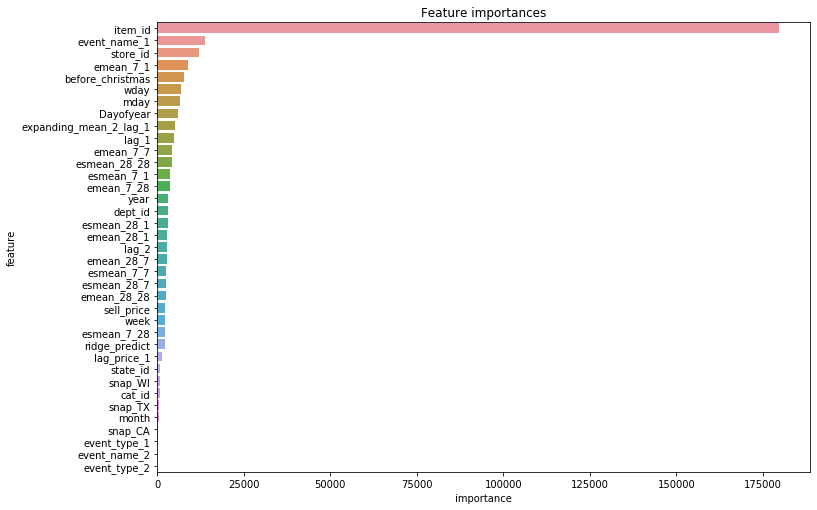

In [56]:
importance = Importance(m_lgb_regressor, 'rmse')
importance.plot_feature_importance(top_n=40)

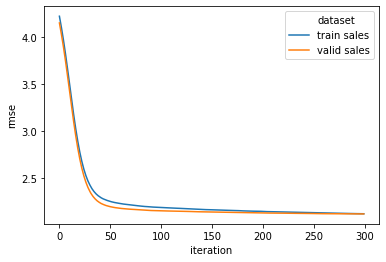

In [57]:
importance.plot_metric()

In [58]:
def save_booster(m_lgb_regressor):
    now = datetime.now()
    booster_file_path = str(path/f'm5_model_{now.day}_{now.month}_{now.year}_{now.hour}')
    m_lgb_regressor.booster_.save_model(booster_file_path)
    return booster_file_path

In [59]:
# for iter in [None, 800, 1000, 1200]:
#     m_lgb_regressor.booster_.save_model(str(path/f"m5_model_{'best' if iter is None else iter}.lgb"), num_iteration=iter)
booster_file_path = save_booster(m_lgb_regressor)

In [60]:
!du -h {booster_file_path}

82M	/kaggle/m5_forecasting/m5_model_18_6_2020_14
